In [ ]:
#@title [Candidature form]

Name = '' #@param {type: "string"}
Matriculation_number = '' #@param {type:"string"}
Faculty = ''  #@param {type: "string"}
Course = '' #@param {type:"string"}
Current_semester = "" #@param ["1", "2", "3", "4", "5", "6", "7"] {allow-input: true}

# Recurrent Neural Networks with LSTMs
## Machine Learning Project - 05 
This project is created and adapted as a Jupyter notebook for [**MME 26849: "Fundamentals of Deep Learning and TinyML"**](https://felix.hs-furtwangen.de/url/RepositoryEntry/4020862983) by the course instructors [Marcus Rüb](https://linkedin.com/in/marcus-rüb-3b07071b2) and [Ajay Krishna](https://linkedin.com/in/ajay-krishna-2031a5119).

## Resouces
Slide from lecture:
[08 - Recurrent Neural Networks](https://github.com/r1marcus/Fundamentals-of-Deep-Learning-HFU/blob/main/Slides/08%20-%20RNN%20Datapre/RNN%20Data.pptx)

## Goal of the project
Implementation of a Long Short Term Memory (LSTM), a recurrent neural network to predict the price of Bitcoin.


## Import libraries 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Load the data

Bitcoin data for our case-study can be found at: https://drive.google.com/file/d/1pVNnJmNkpZJ0h3dsmKCYtgKlemZTKYbY/view?usp=sharing

Steps for loading data:

    1. Press the above link "https://drive.google.com/file/d/1pVNnJmNkpZJ0h3dsmKCYtgKlemZTKYbY/view?usp=sharing"
    2. Download the data to your local machine. (It should be a .csv file)
    3. Press the folder icon on the left in the Colab window and upload "bitcoin_ticker.csv" from your local machine.

In [6]:
data = pd.read_csv("bitcoin_ticker.csv")

View the top 5 rows in the dataset:

In [7]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


## Data Preparation

In [8]:
data['rpt_key'].value_counts()

btc_usd       125438
btc_eur        62719
btc_krw        62719
ltc_usd        62719
eth_btc        62719
fx_btc_jpy     62719
eth_krw        62719
etc_krw        62719
btc_jpy        62719
Name: rpt_key, dtype: int64

We only consider 'btc_usd' attribute for further analysis and exclude all the other Bitcoin to FIAT/cryptocurrencies.

In [13]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


Convert datetime_id to data type and filter dates greater than  2017-06-28 00:00:00

In [15]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [16]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]
df

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.00,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.00,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.00,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.00,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.00,2473.19,20665.357191
...,...,...,...,...,...,...,...,...,...
125433,2017-07-14 13:16:00,2394.03,2500.01,-4.239183,2394.35,2405.72,2378.02,2529.20,1111.540000
125434,2017-07-14 13:17:00,2320.47,2407.06,-3.597335,2320.48,2322.55,2307.46,2413.60,7969.263583
125435,2017-07-14 13:17:00,2394.03,2500.01,-4.239183,2394.42,2405.69,2378.02,2529.20,1111.540000
125436,2017-07-14 13:18:00,2320.47,2408.00,-3.634967,2320.57,2322.55,2307.46,2413.60,7968.970715


 We require only the column 'last', so we subset that and convert it to numpy array.

In [17]:
df = df[['last']]

In [19]:
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh. So we rescale our data to the range of 0 to 1, using MinMaxScaler.

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [21]:
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

In [22]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


Now let us define the function called create_dataset, which takes two inputs:

1. Dataset - numpy array that we want to convert into a dataset
2. look_back - number of previous time steps to use as input variables to predict the next time period

In [23]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [24]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [25]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.53376245, 0.6943617 , 0.53105354, ..., 0.7082124 , 0.5205841 ,
        0.7081547 ],
       [0.6943617 , 0.53105354, 0.70823145, ..., 0.5205841 , 0.7081547 ,
        0.52665424],
       [0.53105354, 0.70823145, 0.5332055 , ..., 0.7081547 , 0.52665424,
        0.7081547 ]], dtype=float32)

In [26]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.52665424, 0.7081547 ,
       0.5206418 ], dtype=float32)

In [27]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Build the Model

In [28]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
125/125 - 18s - loss: 0.1675
Epoch 2/100
125/125 - 0s - loss: 0.0130
Epoch 3/100
125/125 - 0s - loss: 0.0094
Epoch 4/100
125/125 - 0s - loss: 0.0061
Epoch 5/100
125/125 - 0s - loss: 0.0035
Epoch 6/100
125/125 - 0s - loss: 0.0017
Epoch 7/100
125/125 - 0s - loss: 8.0971e-04
Epoch 8/100
125/125 - 0s - loss: 4.5741e-04
Epoch 9/100
125/125 - 0s - loss: 3.3242e-04
Epoch 10/100
125/125 - 0s - loss: 2.7945e-04
Epoch 11/100
125/125 - 0s - loss: 2.5048e-04
Epoch 12/100
125/125 - 0s - loss: 2.3313e-04
Epoch 13/100
125/125 - 0s - loss: 2.2247e-04
Epoch 14/100
125/125 - 0s - loss: 2.1577e-04
Epoch 15/100
125/125 - 0s - loss: 2.1115e-04
Epoch 16/100
125/125 - 0s - loss: 2.0786e-04
Epoch 17/100
125/125 - 0s - loss: 2.0477e-04
Epoch 18/100
125/125 - 0s - loss: 2.0210e-04
Epoch 19/100
125/125 - 0s - loss: 1.9965e-04
Epoch 20/100
125/125 - 0s - loss: 1.9709e-04
Epoch 21/100
125/125 - 0s - loss: 1.9418e-04
Epoch 22/100
125/125 - 0s - loss: 1.9139e-04
Epoch 23/100
125/125 - 0s - loss: 1.8881e-

In [29]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We have to invert the predictions before calculating the error so that the reports will be in the same units as our original data.

In [30]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [31]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 5.21 RMSE
Test Score: 7.03 RMSE


In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [33]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 


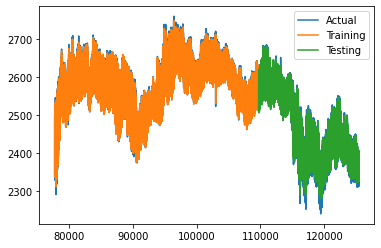

In [34]:
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [36]:
#@title Questionnaire: 
#@markdown 1. What is the purpose of training RNN model?
#@markdown - A) Given character & sequence, what is the most probable next character.
#@markdown - B) Maintaining internal state that depends on previously seen elements.
#@markdown - C) Predict the following character in each time step.
#@markdown - D) Learn patterns and generate a new piece based on model.
Ans = "" #@param ["A", "B", "C","D"] {allow-input: true}

In [ ]:
#@markdown 2. You are training an RNN, and find that your weights and activations are all taking on the value of NaN (“Not a Number”). Which of these is the most likely cause of this problem?
#@markdown - A) Vanishing gradient problem.
#@markdown - B) Exploding gradient problem.

Ans = "" #@param ["A", "B"] {allow-input: true}

In [ ]:
#@markdown 3. RNNs can be used in 
#@markdown - A) Image classification
#@markdown - B) Stocks and Crypto market prediction
#@markdown - C) Planetary movement in Milky Way
#@markdown - D) All of the above
Ans = "" #@param ["A", "B", "C","D"] {allow-input: true}

In [ ]:
#@markdown 4. Consider the following statements:

#@markdown  i. GRU is a generalization of LSTM.

#@markdown ii. Gradient clipping is much effective in handling vanishing gradient problem in an RNN, when compared to the gates in LSTM/GRU.
#@markdown - A) Both i and ii 
#@markdown - B) Only ii 
#@markdown - C) Neither i nor ii 
#@markdown - D) Only i

Ans = "" #@param ["A", "B", "C", "D"] {allow-input: true}

In [ ]:
#@markdown 5. What is t-SNE?
#@markdown - A) A non-linear dimensionality reduction technique.
#@markdown - B) A linear transformation that allows us to solve analogies on word vectors.
#@markdown - C) A supervised learning algorithm for learning word embeddings.
#@markdown - D) An open-source sequence modeling library .

Ans = "" #@param ["A", "B","C","D"] {allow-input: true}